In [3]:
# Import required library
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.svm import SVC
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap
import random
# Load data
data = pd.read_csv("archive/sensor_readings_2.csv", header = None)

# Visualise data as a table
print(data.shape)
data.head(5)

(5456, 3)


,0,1,2
0,1.687,0.445,Slight-Right-Turn
1,1.687,0.449,Slight-Right-Turn
2,1.687,0.449,Slight-Right-Turn
3,1.687,0.449,Slight-Right-Turn
4,1.687,0.449,Slight-Right-Turn


In [4]:
# Define features and classes
data.columns = ['SD_front', 'SD_left', 'Label']
classes = ['Move-Forward', 'Slight-Right-Turn', 'Sharp-Right-Turn', 'Slight-Left-Turn']
class_label = {'Move-Forward': 1, 'Slight-Right-Turn': 2, 'Sharp-Right-Turn': 3, 'Slight-Left-Turn': 4}


condition_1 = data['Label'] == 'Move-Forward'
condition_2 = data['Label'] == 'Slight-Right-Turn'
condition_3 = data['Label'] == 'Sharp-Right-Turn'
condition_4 = data['Label'] == 'Slight-Left-Turn'
true_index_1= condition_1[condition_1 == True].index
true_index_2= condition_2[condition_2 == True].index
true_index_3= condition_3[condition_3 == True].index
true_index_4= condition_4[condition_4 == True].index
print(true_index_1.shape, true_index_2.shape, true_index_3.shape, true_index_4.shape)

(2205,) (826,) (2097,) (328,)


In [5]:
subset_1 = data[condition_1].sample(n = 404)
subset_2 = data[condition_2].sample(n = 151)
subset_3 = data[condition_3].sample(n = 384)
subset_4 = data[condition_4].sample(n = 61)

In [6]:

frames = [subset_1, subset_2, subset_3, subset_4]
new_data = pd.concat(frames)

In [7]:
df = pd.DataFrame (new_data, columns = data.columns)
df = df.sample(frac = 1)
df =df.reset_index(drop = True)

In [8]:
df.head()

,SD_front,SD_left,Label
0,1.731,0.483,Slight-Right-Turn
1,2.222,0.386,Slight-Right-Turn
2,0.808,0.536,Sharp-Right-Turn
3,1.477,0.472,Slight-Right-Turn
4,1.336,0.558,Move-Forward


In [9]:
data_np = df

x_1 = data_np['SD_front'].to_numpy()
x_2 = data_np['SD_left'].to_numpy()
y = data_np['Label'].replace(class_label).to_numpy()

print(y.shape)

(1000,)


In [10]:
# Normalise the data

x1_n = np.linalg.norm(x_1)
x_1 = x_1/x1_n

x2_n = np.linalg.norm(x_2)
x_2 = x_2/x2_n


In [11]:
# Split the data
# 90% for Training set
# 10% for Testing set

TRAIN = 990 # int(data.shape[0] - 10)

# Splitting the data for training giving 90 percent of all samples for each feature
x1_train = x_1[0:TRAIN]
x2_train = x_2[0:TRAIN]
y_train = y[0:TRAIN]
print(x1_train.shape)


# Splitting the data for training giving 10 percent of all samples for each feature
x1_test = x_1[TRAIN:]
x2_test = x_2[TRAIN:]
y_test = y[TRAIN:]
print(x1_test.shape)


(990,)
(10,)


In [12]:
X_train = np.array((x1_train, x2_train))
X_train = X_train.T

X_test = np.array((x1_test, x2_test))
X_test = X_test.T

In [13]:
def classify(y, c):
    ova_ = []
    for i in range(y.shape[0]):
        if y[i] != c:
            ova_.append(-1)
        else:
            ova_.append(1)
    return ova_


In [14]:
classified_a = np.array(classify(y_train, 1))
classified_b = np.array(classify(y_train, 2))
classified_c = np.array(classify(y_train, 3))
classified_d = np.array(classify(y_train, 4))


In [49]:
class SVM:
    def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
        self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**degree,
                'rbf'   : lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)),
                'linear': lambda x,y: np.dot(x, y.T)}[kernel]
        self.C = C
        self.max_iter = max_iter

    def restrict_to_square(self, t, v0, u):
        t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
        return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

    def fit(self, X, y):
        self.X = X.copy()
        self.y = y
        self.lambdas = np.zeros_like(self.y, dtype=float)
        self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y

        for _ in range(self.max_iter):
            for idxM in range(len(self.lambdas)):
                idxL = np.random.randint(0, len(self.lambdas))
                Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
                v0 = self.lambdas[[idxM, idxL]]
                k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
                u = np.array([-self.y[idxL], self.y[idxM]])
                t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
                self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)

        idx, = np.nonzero(self.lambdas > 1E-15)
        self.b = np.mean((1.0 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx])

    def decision_function(self, X):
        return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

    def predict(self, X):
        return (np.sign(self.decision_function(X)) + 1) // 2


def test_plot(X, y, svm_model, axes, title):
    plt.axes(axes)
    xlim = [np.min(X[:, 0]), np.max(X[:, 0])]
    ylim = [np.min(X[:, 1]), np.max(X[:, 1])]
    xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
    rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0

    svm_model.fit(X, y)
    z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
    plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
    plt.title(title)


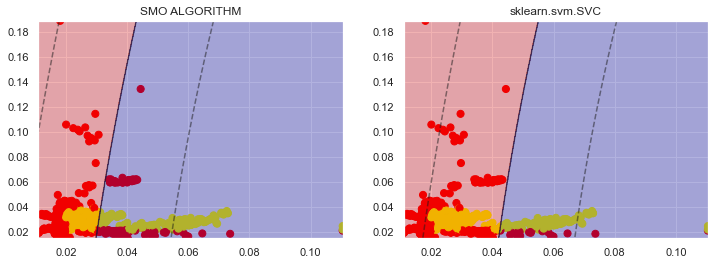

In [27]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X_train, classified_a, SVM(kernel='rbf', C=10, max_iter=60, gamma=1), axs[0], 'SMO ALGORITHM')
test_plot(X_train, classified_a, SVC(kernel='rbf', C=10, gamma=1), axs[1], 'sklearn.svm.SVC')

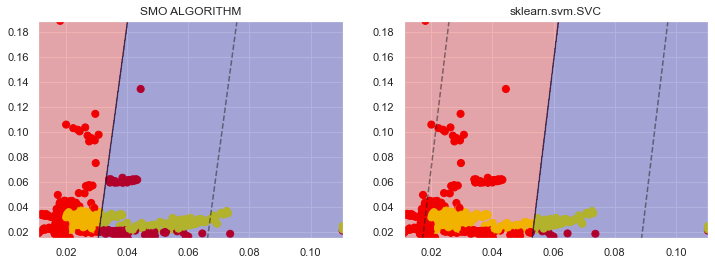

In [16]:
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X_train, classified_a, SVM(kernel='linear', C=10, max_iter=60), axs[0], 'SMO ALGORITHM')
test_plot(X_train, classified_a, SVC(kernel='linear', C=10), axs[1], 'sklearn.svm.SVC')

In [47]:
model = SVM(kernel='rbf', C=10, max_iter=60, gamma=1)
model.fit(X_train, classified_a)
model.predict(X_test)

array([1., 1., 0., 0., 0., 0., 1., 0., 1., 1.])

In [50]:
print(y_test)

[2 2 3 3 1 3 1 3 1 2]


In [52]:
model = SVM(kernel='rbf', C=10, max_iter=60, gamma=1)
model.fit(X_train, classified_c)
model.predict(X_test)

array([0., 0., 1., 1., 1., 1., 0., 1., 0., 0.])

In [53]:
model = SVM(kernel='rbf', C=10, max_iter=60, gamma=1)
model.fit(X_train, classified_d)
model.predict(X_test)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])